# Set up 

In [1]:
import numpy as np
import pandas as pd 
import unidecode
import unicodedata
import datetime
import random
import os
from datetime import datetime
from datetime import timedelta

## Import data

In [2]:
districts = pd.read_csv('Partidos.csv', sep=',')
districts0 = pd.read_csv('Partidos.csv', sep=',')

In [3]:
calls = pd.read_csv('calls.csv', sep=',')
cases = pd.read_csv('cases.csv', sep=',')

# Parse and normalize data 

## Process: Cases  

In [4]:
# This function converts all to lower-case and no spaces
def reduce(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if unicodedata.category(x)[0] == 'L').lower()

In [5]:
for i in range(len(cases)):
    j = str(cases.iloc[i]['Municipio'])
    if j != 'nan': 
        tmpname = reduce(j)
        cases.iloc[i,cases.columns.get_loc('Municipio')] = tmpname

In [6]:
cases['fecha_apertura'] = pd.to_datetime(cases['fecha_apertura'])
cases['fecha_apertura'] = cases['fecha_apertura'].dt.date

In [7]:
display(cases[:4])
print(len(cases))

,residencia_provincia_nombre,Municipio,FIS,fecha_apertura,CLASIF_RESUMEN
0,Buenos Aires,tresdefebrero,2020-02-27,2020-03-04,Confirmado
1,Buenos Aires,vicentelopez,2020-03-05,2020-03-07,Confirmado
2,Buenos Aires,vicentelopez,2020-03-05,2020-03-09,Confirmado
3,Buenos Aires,lamatanza,2020-03-03,2020-03-09,Confirmado


41323


## Process: Calls

In [8]:
# Replace the 2 unmatching names
for i in range(len(calls)):
    j = str(calls.iloc[i]['Municipio'])
    if j != 'nan': 
        if j == 'NUEVE DE JULIO': j = '9 de julio'
        if j == 'CORONEL DE MARINA LEONARDO ROSALES': j = 'CORONEL DE MARINA L ROSALES'
        tmpname = reduce(j)
        calls.iloc[i,calls.columns.get_loc('Municipio')] = tmpname
    if j == 'nan': calls.iloc[i,calls.columns.get_loc('Municipio')] = tmpname

In [9]:
calls.rename(columns={'Fecha_Alta': 'Fecha y hora'}, inplace=True)

In [10]:
calls['Fecha y hora'] = pd.to_datetime(calls['Fecha y hora'])
calls['Fecha y hora'] = calls['Fecha y hora'].dt.date

In [11]:
display(calls[:4])
print(len(calls))

,Fecha y hora,Municipio
0,2020-04-23,adolfoalsina
1,2020-06-08,adolfoalsina
2,2020-06-22,adolfoalsina
3,2020-06-27,adolfoalsina


38595


## Process: Partidos

In [12]:
# Just reduce the names
for i in range(len(districts)):
    j = str(districts.iloc[i]['Municipio'])
    if j != 'nan': 
        tmpname = reduce(j)
        districts.iloc[i,districts.columns.get_loc('Municipio')] = tmpname

In [13]:
display(districts[:4])
print(len(districts))

,Partido,Municipio,Poblacion,Cordon
0,1,lamatanza,1772130,1
1,2,laplata,649613,3
2,3,generalpueyrredon,614350,3
3,4,lomasdezamora,613192,1


134


## Up to now:

We have 3 dataframes, one for the **cases**, other for the **calls**, and a third for all the **districts**. 

# Let's define the data points

We divide the dates in n days and for each district we check how many calls and new cases there are in those n-days.  We feed a to-be-fitted with each one of these data points.

In [14]:
# Max and Min date for calls
ticalls=min(calls['Fecha y hora'].tolist())
tfcalls=max(calls['Fecha y hora'].tolist())
print (ticalls," ",tfcalls)
print (tfcalls-ticalls)

2020-03-02   2020-07-07
127 days, 0:00:00


In [15]:
# Max and Min date for cases
ticases=min(cases['fecha_apertura'].tolist())
tfcases=max(cases['fecha_apertura'].tolist())
print (ticases," ",tfcases)
print (tfcases-ticases)

2020-03-04   2020-07-06
124 days, 0:00:00


In [16]:
print(ticalls)
print(tfcases)
print(tfcases-ticalls)

2020-03-02
2020-07-06
126 days, 0:00:00


In [17]:
# We define the date slice where to do the fit
tisurvey = ticalls+timedelta(days=60)
tfsurvey = tfcases-timedelta(days=10)
print("Full survey duration:", tfsurvey - tisurvey )
print(tisurvey,' to ', tfsurvey)

Full survey duration: 56 days, 0:00:00
2020-05-01  to  2020-06-26


In [18]:
# Define tine window on which to run
# Observe that we start in ticalls and end in tfcases so that we always have both cases and calls in any slice in between
ndays = 28
dateslices = int((tfsurvey - tisurvey ).days / ndays )
print(dateslices)

2


### We create the data table  

['N_calls','N_inhabitants','N_cases']

for each data-point

In [19]:
Data=[]
delay=0
for n_district in range(len(districts)):
    # Iterate on the district names
    tmp_district = districts['Municipio'][n_district]
    N_inhabitants = districts['Poblacion'][n_district]
    print("Computing district #: ",n_district," (",tmp_district,")")
    # Iterate on all the date-slices
    for n_dates in range(dateslices):
        # First: count how many calls within the dataslice from district tmp_district
        N_calls = len(calls[(calls['Fecha y hora'] >= tisurvey + timedelta(days=n_dates*ndays) ) & (calls['Fecha y hora'] < tisurvey + timedelta(days = (n_dates+1)*ndays) ) & (calls['Municipio'] == tmp_district)])
    
        # Second: count how many cases within dataslice from district tmp_district
        N_cases = len(cases[(cases['fecha_apertura'] >= tisurvey + timedelta(days=n_dates*ndays) ) & (cases['fecha_apertura'] < tisurvey + timedelta(days = (n_dates+1)*ndays) ) & (cases['Municipio'] == tmp_district)])
        
        # Now we can append to the data array this datapoint
        if n_dates == 0:
            slice_dates = "2020-05-01 to 2020-05-28"
        else:
            slice_dates = "2020-05-29 to 2020-06-26"
        if N_calls > 0:
            Data.append([N_calls,N_inhabitants,N_cases,tmp_district,slice_dates])
        #print("  Dataslice #: ",n_dates)
    

Computing district #:  0  ( lamatanza )
Computing district #:  1  ( laplata )
Computing district #:  2  ( generalpueyrredon )
Computing district #:  3  ( lomasdezamora )
Computing district #:  4  ( quilmes )
Computing district #:  5  ( almirantebrown )
Computing district #:  6  ( merlo )
Computing district #:  7  ( moreno )
Computing district #:  8  ( lanus )
Computing district #:  9  ( florenciovarela )
Computing district #:  10  ( generalsanmartin )
Computing district #:  11  ( sanmiguel )
Computing district #:  12  ( tigre )
Computing district #:  13  ( tresdefebrero )
Computing district #:  14  ( avellaneda )
Computing district #:  15  ( malvinasargentinas )
Computing district #:  16  ( berazategui )
Computing district #:  17  ( moron )
Computing district #:  18  ( bahiablanca )
Computing district #:  19  ( estebanecheverria )
Computing district #:  20  ( pilar )
Computing district #:  21  ( sanisidro )
Computing district #:  22  ( vicentelopez )
Computing district #:  23  ( josecp

In [20]:
# The data array has in each row an independent data-point of 
# "How many calls in a given population with a given number of new cases"
display(Data[:10])
print("Number of data points: ",len(Data))

[[686, 1772130, 527, 'lamatanza', '2020-05-01 to 2020-05-28'],
 [3194, 1772130, 3304, 'lamatanza', '2020-05-29 to 2020-06-26'],
 [245, 649613, 91, 'laplata', '2020-05-01 to 2020-05-28'],
 [497, 649613, 611, 'laplata', '2020-05-29 to 2020-06-26'],
 [37, 614350, 20, 'generalpueyrredon', '2020-05-01 to 2020-05-28'],
 [12, 614350, 13, 'generalpueyrredon', '2020-05-29 to 2020-06-26'],
 [198, 613192, 207, 'lomasdezamora', '2020-05-01 to 2020-05-28'],
 [1091, 613192, 1482, 'lomasdezamora', '2020-05-29 to 2020-06-26'],
 [297, 580829, 477, 'quilmes', '2020-05-01 to 2020-05-28'],
 [990, 580829, 1745, 'quilmes', '2020-05-29 to 2020-06-26']]

Number of data points:  136


In [21]:
# We restrict to those data-points with at least 100 calls
data0 = pd.DataFrame(Data,columns=['calls','population','cases','district','dates-slice'])
data0 = data0[data0['calls']>100].reset_index(drop=True)
len(data0)

43

In [22]:
data0

,calls,population,cases,district,dates-slice
0,686,1772130,527,lamatanza,2020-05-01 to 2020-05-28
1,3194,1772130,3304,lamatanza,2020-05-29 to 2020-06-26
2,245,649613,91,laplata,2020-05-01 to 2020-05-28
3,497,649613,611,laplata,2020-05-29 to 2020-06-26
4,198,613192,207,lomasdezamora,2020-05-01 to 2020-05-28
5,1091,613192,1482,lomasdezamora,2020-05-29 to 2020-06-26
6,297,580829,477,quilmes,2020-05-01 to 2020-05-28
7,990,580829,1745,quilmes,2020-05-29 to 2020-06-26
8,197,555731,170,almirantebrown,2020-05-01 to 2020-05-28
9,750,555731,1011,almirantebrown,2020-05-29 to 2020-06-26


# Fit

In [23]:
import math
from math import sqrt
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [24]:
calls4fit = data0['calls'].to_list()
population4fit = data0['population'].to_list()
cases4fit = data0['cases'].to_list()

## Null Hypothesis  (i.e. do not consider that cases affect the number of calls)

In [26]:
def func(p, f0):
    return p*f0 
all_calls = np.array(calls4fit)
all_people = np.array(population4fit)

h0, h0cov = curve_fit(func, all_people, all_calls)
print("There are ",'{:0.2e}'.format(h0[0]/ndays),"+/-",'{:0.2e}'.format(sqrt(h0cov[0][0])/ndays)," calls for each inhabitant/day")

There are  3.66e-05 +/- 3.66e-06  calls for each inhabitant/day


In [28]:
# Compute R2
SSres=sum([(all_calls[i]-(all_people[i]*h0[0]))**2 for i in range(len(all_calls))])
yaverage = np.mean(all_calls)
SStot=sum([(all_calls[i]-yaverage)**2 for i in range(len(all_calls))])
R2 = round(1 - SSres/SStot,2)
R20 = R2
print('R²=',R2,' <= Not a good fit if we do not consider the cases')

R²= 0.48  <= Not a good fit if we do not consider the cases


## Calls correlated to cases Hypotheses 

In [29]:
def func(X, f1, Na):
    p,i = X
    return p * f1 + i * Na 
all_calls = np.array(calls4fit)
all_people = np.array(population4fit)
all_cases = np.array(cases4fit)
h1, h1cov = curve_fit(func, (all_people,all_cases),all_calls)
print (h1,'\n',h1cov)

[2.27169483e-04 6.88036940e-01] 
 [[ 4.86578720e-09 -2.65801679e-06]
 [-2.65801679e-06  2.29360615e-03]]


In [30]:
fp = h1[0]/ndays
fi = h1[1]
Dfp = sqrt(h1cov[0][0])/ndays
Dfi = sqrt(h1cov[1][1])

In [31]:
print("There are ",'{:0.2e}'.format(h1[0]/ndays),"+/-",'{:0.2e}'.format(sqrt(h1cov[0][0])/ndays)," calls for each inhabitant per day")
print("There are ",round(h1[1],2),"+/-",round(sqrt(h1cov[1][1]),2)," calls for each case")

There are  8.11e-06 +/- 2.49e-06  calls for each inhabitant per day
There are  0.69 +/- 0.05  calls for each case


In [33]:
# define the Signal, Background parameters for next section
B = h1[0]/ndays
DB = sqrt(h1cov[0][0])/ndays
S = h1[1]
DS = sqrt(h1cov[1][1])
S95 = S 
print(S,DS,B,DB)

0.6880369400790102 0.04789160830474055 8.113195828956294e-06 2.491256956648139e-06


In [34]:
scatt=[(all_calls[i],all_people[i]*h1[0]+all_cases[i]*h1[1]) for i in range(len(all_calls))]
# Compute R2
SSres=sum([(all_calls[i]-(all_people[i]*h1[0]+all_cases[i]*h1[1]))**2 for i in range(len(all_calls))])
yaverage = np.mean(all_calls)
SStot=sum([(all_calls[i]-yaverage)**2 for i in range(len(all_calls))])
R2 = round(1 - SSres/SStot,2)
print(R2)

0.91


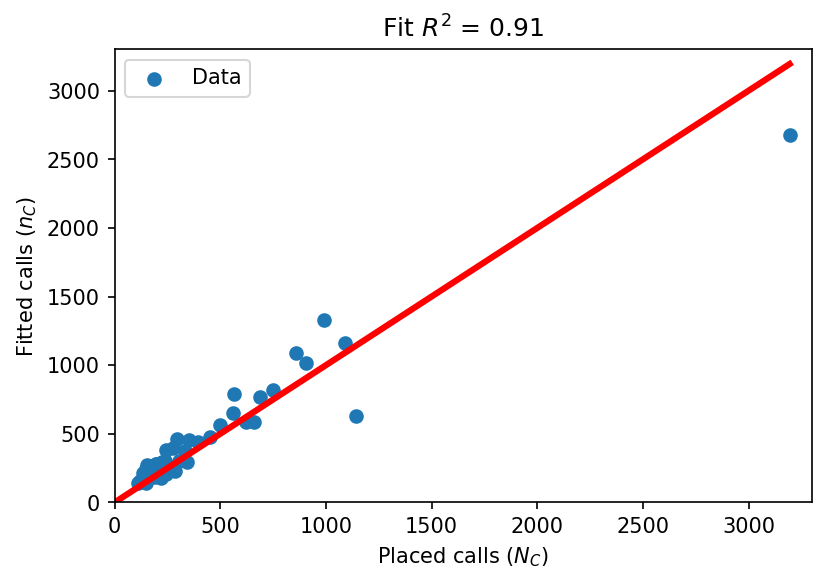

In [37]:
scatt0=[(all_calls[i],all_people[i]*h1[0]+all_cases[i]*h1[1]) for i in range(len(all_calls))]
scatt1=[(all_people[i],all_people[i]*h1[0]+all_cases[i]*h1[1]) for i in range(len(all_calls))]
scatt2=[(all_people[i],all_calls[i]) for i in range(len(all_calls))]
# Plot 1
plt.figure(dpi=150)
plt.scatter(*zip(*scatt),label="Data")
plt.legend()
plt.plot([0,max(all_calls)], [0,max(all_calls)], linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.ylim(0, 3300)
plt.xlim(0, 3300)
plt.xlabel("Placed calls ($N_C$)")
plt.ylabel("Fitted calls ($n_C$)")
plt.title('Fit $R^2$ = '+str(R2))
#plt.savefig('figs/fit_paper_2.png')
plt.show()

# We use the fit parameters to study the data

In [39]:
# Choose a date from which you want to perform the analysis
import datetime
today = datetime.date(2020,5,20)
print(today)

2020-05-20


In [41]:
# We create a table that for each districts tells how many calls (calls1,calls2,etc) were in the last n days and their uncertainty (Delt1,Delta2,etc)
from datetime import datetime
data=[]
for n_district in range(len(districts)):
    # Iterate on the district names
    tmp_district = districts['Municipio'][n_district]
    N_inhabitants = districts['Poblacion'][n_district]
    print("Computing district #: ",n_district," (",tmp_district,")")
    # Go through the whole calls df
    calls1 = len(calls[(calls['Fecha y hora'] < today ) & (calls['Fecha y hora'] >= today - timedelta(days=1)) & (calls['Municipio'] == tmp_district)])
    calls2 = len(calls[(calls['Fecha y hora'] < today ) & (calls['Fecha y hora'] >= today - timedelta(days=2)) & (calls['Municipio'] == tmp_district)])
    calls3 = len(calls[(calls['Fecha y hora'] < today ) & (calls['Fecha y hora'] >= today - timedelta(days=3)) & (calls['Municipio'] == tmp_district)])
    calls4 = len(calls[(calls['Fecha y hora'] < today ) & (calls['Fecha y hora'] >= today - timedelta(days=4)) & (calls['Municipio'] == tmp_district)])
    Delta1 = len(calls[(calls['Fecha y hora'] == today - timedelta(days=1)) & (calls['Municipio'] == tmp_district)])
    Delta2 = len(calls[(calls['Fecha y hora'] == today - timedelta(days=2)) & (calls['Municipio'] == tmp_district)])
    Delta3 = len(calls[(calls['Fecha y hora'] == today - timedelta(days=3)) & (calls['Municipio'] == tmp_district)])
    Delta4 = len(calls[(calls['Fecha y hora'] == today - timedelta(days=4)) & (calls['Municipio'] == tmp_district)])
    Delta5 = len(calls[(calls['Fecha y hora'] == today - timedelta(days=5)) & (calls['Municipio'] == tmp_district)])
    Delta6 = len(calls[(calls['Fecha y hora'] == today - timedelta(days=6)) & (calls['Municipio'] == tmp_district)])    
    expected_calls = B * N_inhabitants
    data.append([tmp_district, N_inhabitants, expected_calls, calls1, calls2, calls3, calls4, Delta1, Delta2, Delta3, Delta4, Delta5, Delta6])

Computing district #:  0  ( lamatanza )
Computing district #:  1  ( laplata )
Computing district #:  2  ( generalpueyrredon )
Computing district #:  3  ( lomasdezamora )
Computing district #:  4  ( quilmes )
Computing district #:  5  ( almirantebrown )
Computing district #:  6  ( merlo )
Computing district #:  7  ( moreno )
Computing district #:  8  ( lanus )
Computing district #:  9  ( florenciovarela )
Computing district #:  10  ( generalsanmartin )
Computing district #:  11  ( sanmiguel )
Computing district #:  12  ( tigre )
Computing district #:  13  ( tresdefebrero )
Computing district #:  14  ( avellaneda )
Computing district #:  15  ( malvinasargentinas )
Computing district #:  16  ( berazategui )
Computing district #:  17  ( moron )
Computing district #:  18  ( bahiablanca )
Computing district #:  19  ( estebanecheverria )
Computing district #:  20  ( pilar )
Computing district #:  21  ( sanisidro )
Computing district #:  22  ( vicentelopez )
Computing district #:  23  ( josecp

In [42]:
# Using the previous table we now create an 'alarm' table that has the estimated number of cases in each slice 
# of the previous n days, as well as their ucertainty
alarm=[]
for i in range(len(data)):
    
    cases1 = (data[i][3] - 1 * (data[i][2]) )/S95
    Dcases1 = sqrt( (DB * 1 * data[i][1])**2 + 0 * data[i][1] + data[i][3] )/S95
    
    cases2 = (data[i][4] - 2 * (data[i][2]))/S95
    Dcases2 = sqrt( ( DB * 2 * data[i][1])**2 + 2 * 0 * data[i][1] + data[i][4] )/S95
    
    cases3 = (data[i][5] - 3 * (data[i][2]))/S95
    Dcases3 = sqrt( ( DB * 3 * data[i][1])**2 + 3 * 0 * data[i][1] + data[i][5] )/S95
    
    cases4 = (data[i][6] - 4* (data[i][2]))/S95
    Dcases4 = sqrt( ( DB * 4 * data[i][1])**2 + 4 * 0 * data[i][1] + data[i][6] )/S95
    
    casesDelta1 = (data[i][7] - 1* data[i][2])/S95
    casesDelta2 = (data[i][8] - 1* data[i][2])/S95
    casesDelta3 = (data[i][9] - 1* data[i][2])/S95
    casesDelta4 = (data[i][10] - 1* data[i][2])/S95
    casesDelta5 = (data[i][11] - 1* data[i][2])/S95
    casesDelta6 = (data[i][12] - 1* data[i][2])/S95
    
    xi_casesDelta1 = sqrt( ( DB * data[i][1])**2 + 0 * data[i][1] + data[i][7] )/S95
    xi_casesDelta2 = sqrt( ( DB * data[i][1])**2 + 0 * data[i][1] + data[i][8] )/S95
    xi_casesDelta3 = sqrt( ( DB * data[i][1])**2 + 0 * data[i][1] + data[i][9] )/S95
    
    alarm.append([districts0['Municipio'][i],districts['Poblacion'][i], cases1, Dcases1, cases2, Dcases2, cases3, Dcases3, cases4, Dcases4, casesDelta1, casesDelta2, casesDelta3, casesDelta4, casesDelta5, casesDelta6, xi_casesDelta1, xi_casesDelta2, xi_casesDelta3])

In [43]:
# We create a table with the estimated cases per day using the last 2 days info, and sort it according 
# to their significance
# absolute = [Municipio, cases, 95%CL uncertainty, minimum cases @ 95%CL]
absolute2 = [[x[0],x[4]/2,x[5]/2,(x[4]-x[5])/2] for x in alarm]
absolute2.sort(key=lambda x:-x[3])
# relative = [Municipio, cases per 100k, 95%CL uncertainty, minimum cases per 100k @ 95%CL]
relative2 = [[x[0],x[4]*100000/(2*x[1]),x[5]*100000/(2*x[1]),(x[4]-x[5])*100000/(2*x[1]) ] for x in alarm]
relative2.sort(key=lambda x:-x[3])

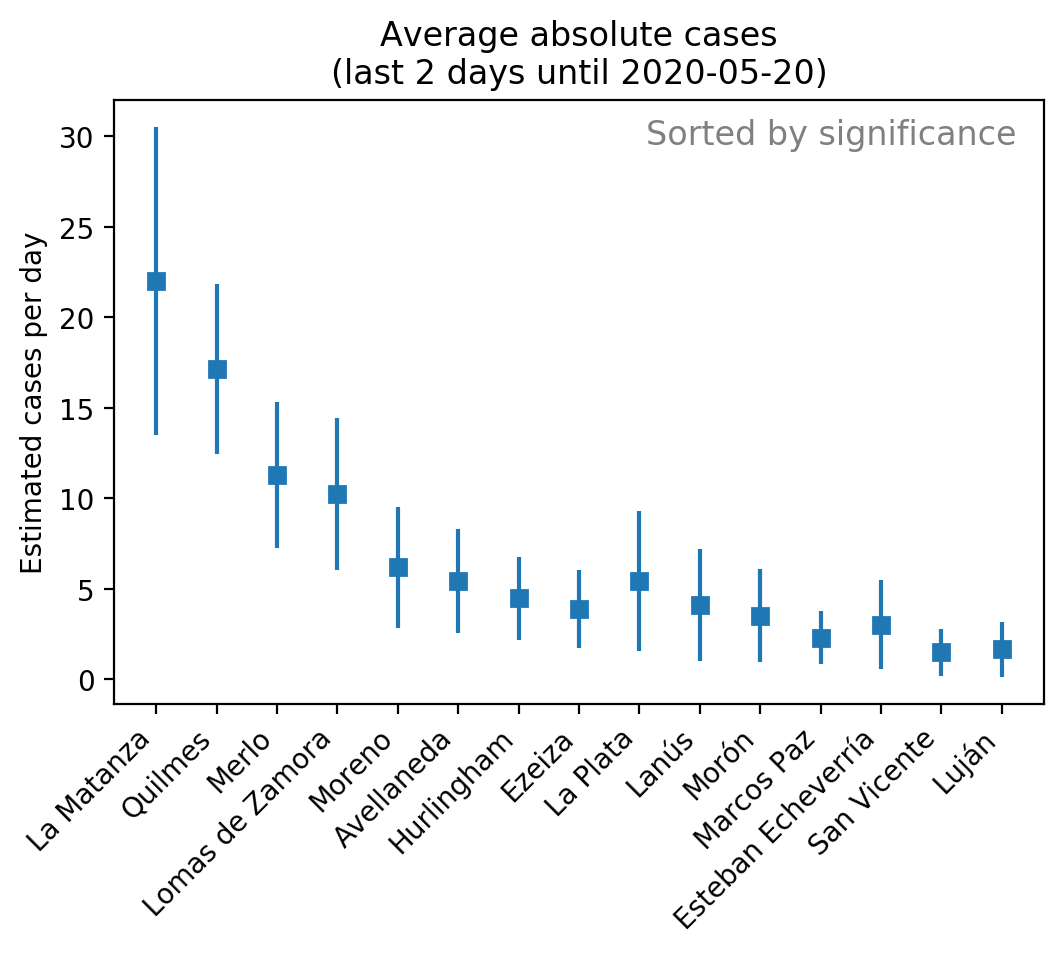

In [56]:
# Create plot using top districts in absolute values
testlist = absolute2[:15]
x = range(len(testlist))
y = [x[1] for x in testlist]
e = [x[2] for x in testlist]
plt.figure(dpi=200)
plt.errorbar(x, y, yerr=e, fmt='s')
plt.xticks(x, [x[0] for x in testlist], rotation=45, ha='right')
plt.ylabel('Estimated cases per day')
plt.title('Average absolute cases\n(last 2 days until '+str(today)+')')
plt.text(.97,.97,'Sorted by significance',ha='right',va='top', fontsize=12, color='gray',transform = plt.gca().transAxes)
if not os.path.isdir('figs'): os.makedirs('figs')
plt.savefig('figs/quilmes_last_2_days_2020-05-20.png',bbox_inches='tight')
plt.show()

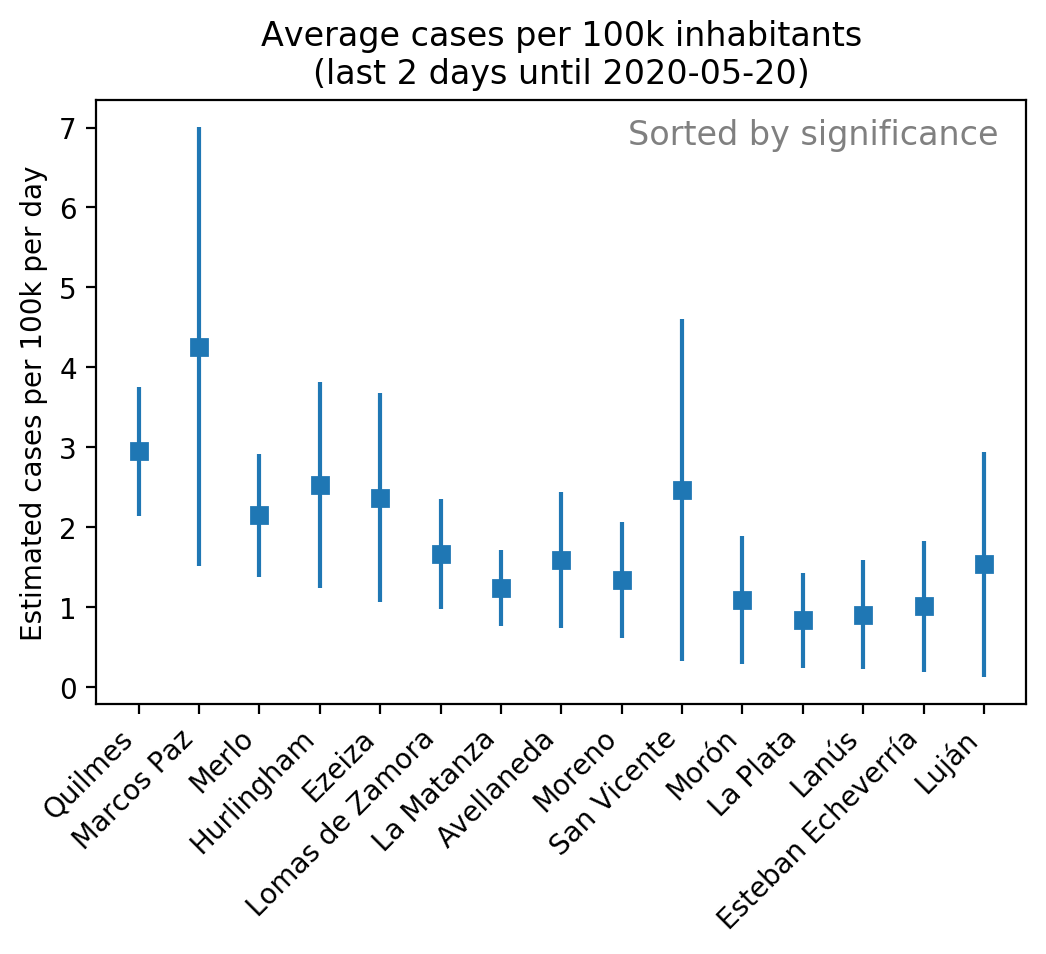

In [55]:
# Create plot using top districts in relative to 100k inhabitants values
testlist = relative2[:15]
x = range(len(testlist))
y = [x[1] for x in testlist]
e = [x[2] for x in testlist]
plt.figure(dpi=200)
plt.errorbar(x, y, yerr=e, fmt='s')
plt.xticks(x, [x[0] for x in testlist], rotation=45, ha='right')
plt.ylabel('Estimated cases per 100k per day')
plt.title('Average cases per 100k inhabitants\n(last 2 days until '+str(today)+')')
plt.text(.97,.97,'Sorted by significance',ha='right',va='top', fontsize=12, color='gray',transform = plt.gca().transAxes)
if not os.path.isdir('figs'): os.makedirs('figs')
plt.savefig('figs/quilmes_last_2_days_100k_2020-05-20.png',bbox_inches='tight')
plt.show()

# Create Tendency Tables 

In [46]:
# Define function to fit (straight line using last 3 days)
def func(x, m, b):
        return m * x + b
xdata = np.array([-3,-2,-1])
tendency=[]
for i in range(len(alarm)):
    ydata = np.array([alarm[i][12],alarm[i][11],alarm[i][10]])
    sigmas = np.array([alarm[i][18],alarm[i][17],alarm[i][16]])
    # We fit using the uncertainty in the data.  Here is a non-fully satisfactory explanation on how it works the sigma: https://stackoverflow.com/questions/31704940/using-the-absolute-sigma-parameter-in-scipy-optimize-curve-fit
    popt, pcov = curve_fit(func, xdata, ydata, sigma=sigmas, absolute_sigma=True)
    if pcov[0][0] < 0 : pcov[0][0] = 50  #lo agregue porque si no hay  un bug numerico a veces
    #print(i,popt,pcov)
    tendency.append([districts0['Municipio'][i],districts['Poblacion'][i], popt[0], math.sqrt(pcov[0][0]),popt[0]/math.sqrt(pcov[0][0]),popt[1]])

/home/sequi/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


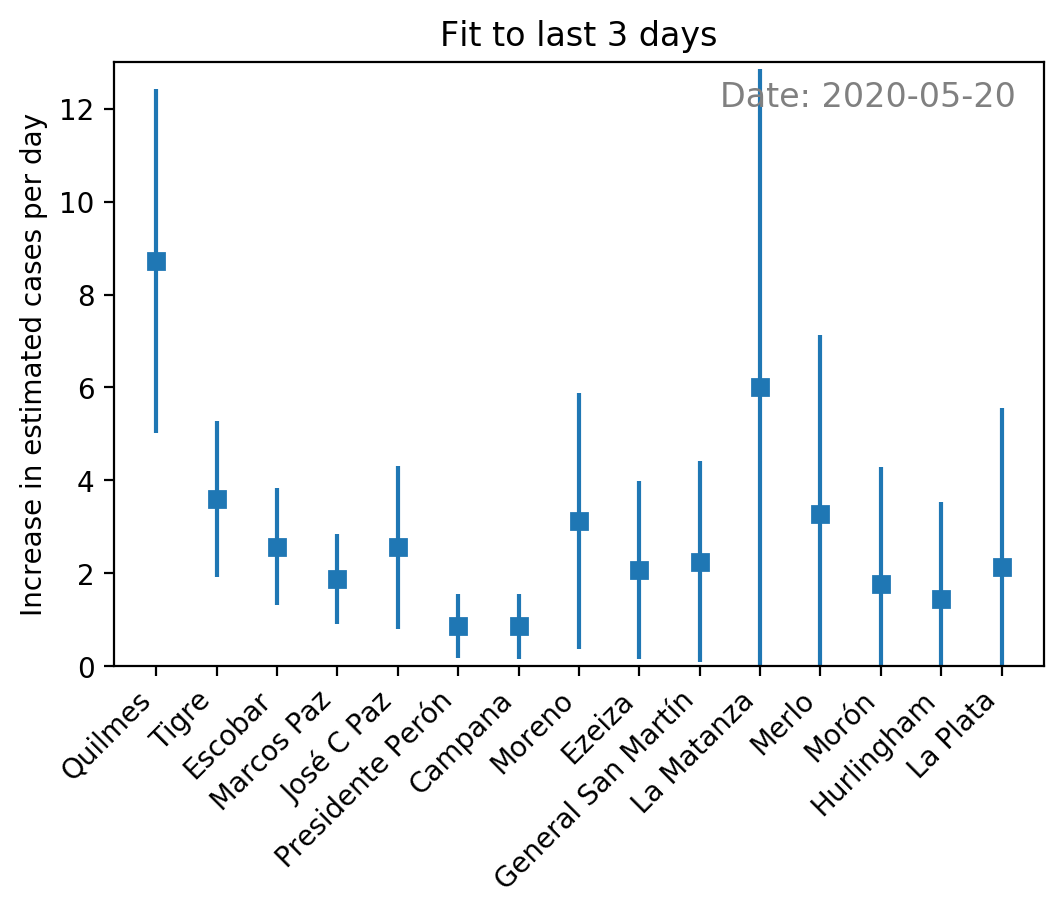

In [54]:
tendency.sort(key=lambda x:-x[4])
testlist = tendency[:15]
#print(testlist[:3])
x = range(len(testlist))
y = [x[2] for x in testlist]
e = [x[3] for x in testlist]
plt.figure(dpi=200)
plt.text(.97,.97,'Date: '+str(today),ha='right',va='top', fontsize=12, color='gray',transform = plt.gca().transAxes)
plt.errorbar(x, y, yerr=e, fmt='s')
plt.xticks(x, [x[0] for x in testlist], rotation=45, ha='right')
plt.ylim((0,13))
plt.ylabel('Increase in estimated cases per day')
plt.title('Fit to last 3 days')
if not os.path.isdir('figs'): os.makedirs('figs')
plt.savefig('figs/tendency_paper_early-alarm.png',bbox_inches='tight')
plt.show()

## Create featured plots

Plot will be from  2020-05-05  to  2020-05-20


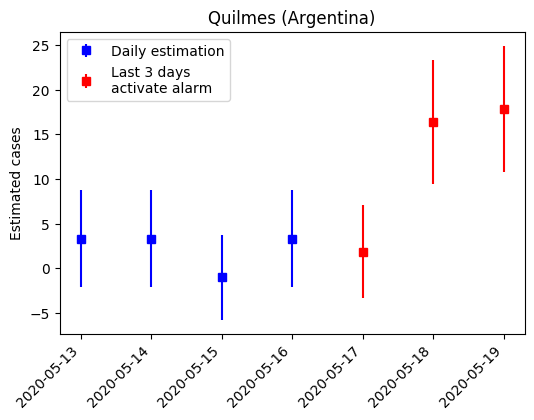

In [53]:
import datetime
testmuni = 'quilmes'
today = datetime.date(2020,5,20)

key=districts.index[districts['Municipio'] == testmuni].tolist()
fromday = today - timedelta(days=15)
print('Plot will be from ',fromday,' to ',today)

import datetime
delta = today - fromday
Ndays = int(delta.days)
data_individual=[]
for ndays in range(Ndays):    
    testday = fromday + timedelta(days=ndays)
    #print('Collecting calls from day '+str(testday)+' and district '+testmuni)
    n_district = key[0]
    # Iterate on the district names
    tmp_district = districts['Municipio'][n_district]
    N_inhabitants = districts['Poblacion'][n_district]
    # Go through the whole calls df
    calls0 = 0
    Delta0 = 0
    calls0 = len(calls[(calls['Municipio'] == tmp_district) & (calls['Fecha y hora'] == testday)])

    expected_calls = B * N_inhabitants
    data_individual.append([tmp_district, N_inhabitants, expected_calls, calls0, testday])

alarm0=[]
for i in range(len(data_individual)):
    
    cases0 = (data_individual[i][3] - data_individual[i][2] )/S95
    Dcases0 = sqrt( ( DB * data_individual[i][1])**2 + data_individual[i][2] + data_individual[i][3])/S95
    
    alarm0.append([districts0['Municipio'][key[0]],districts['Poblacion'][key[0]], cases0, Dcases0, data_individual[i][-1]])

# absolute = [Municipio, cases, 95%CL uncertainty, minimum cases @ 95%CL]
absolute0 = [[x[0],x[2],x[3],x[-1]] for x in alarm0]

testlist = absolute0[-7:]
x = [x[-1] for x in testlist[:-3]]
y = [x[1] for x in testlist[:-3]]
e = [x[2]/1 for x in testlist[:-3]]
x1 = [x[-1] for x in testlist[-3:]]
y1 = [x[1] for x in testlist[-3:]]
e1 = [x[2]/1 for x in testlist[-3:]]
plt.figure(dpi=100)
plt.errorbar(x, y, yerr=e, fmt='s', color='blue', label='Daily estimation')
plt.errorbar(x1, y1, yerr=e1, fmt='s', color='red', label='Last 3 days\nactivate alarm')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Estimated cases')
plt.title(str(testlist[0][0])+' (Argentina)')
plt.legend(loc=2)
if not os.path.isdir('figs'): os.makedirs('figs')
plt.savefig('figs/quilmes_villa_azul.png',bbox_inches='tight')
plt.show()


Plot will be from  2020-05-13  to  2020-06-09


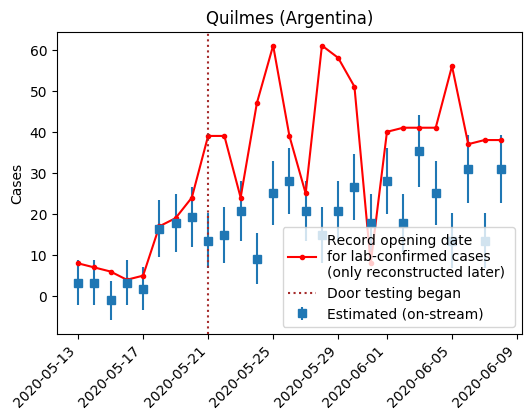

In [52]:
# Introduce district name from list
import datetime
testmuni = 'quilmes'
today = datetime.date(2020,6,9)

key=districts.index[districts['Municipio'] == testmuni].tolist()
fromday = today - timedelta(days=27)
print('Plot will be from ',fromday,' to ',today)

real_cases = []
import datetime
delta = today - fromday
Ndays = int(delta.days)
data_individual=[]
for ndays in range(Ndays):    
    testday = fromday + timedelta(days=ndays)
    n_district = key[0]
    # Iterate on the district names
    tmp_district = districts['Municipio'][n_district]
    N_inhabitants = districts['Poblacion'][n_district]
    # Go through the whole calls df
    calls0 = 0
    Delta0 = 0
    calls0 = len(calls[(calls['Municipio'] == tmp_district) & (calls['Fecha y hora'] == testday)])
    real_cases.append([testday,len(cases[(cases['Municipio'] == tmp_district) & (cases['fecha_apertura'] == testday)])])
    expected_calls = B * N_inhabitants
    data_individual.append([tmp_district, N_inhabitants, expected_calls, calls0, testday])

alarm0=[]
for i in range(len(data_individual)):
    
    cases0 = (data_individual[i][3] - data_individual[i][2])/S95
    Dcases0 = sqrt( ( DB * data_individual[i][1])**2 + data_individual[i][2] + data_individual[i][3])/S95
    
    alarm0.append([districts0['Municipio'][key[0]],districts['Poblacion'][key[0]], cases0, Dcases0, data_individual[i][-1]])

# absolute = [Municipio, cases, 95%CL uncertainty, minimum cases @ 95%CL]
absolute0 = [[x[0],x[2],x[3],x[-1]] for x in alarm0]

testlist = absolute0
#x = range(len(testlist))
x = [x[-1] for x in testlist]
y = [x[1] for x in testlist]
e = [x[2]/1 for x in testlist]
plt.figure(dpi=100)
plt.errorbar(x, y, yerr=e, fmt='s',label='Estimated (on-stream)')
plt.plot([x[0] for x in real_cases],[x[1] for x in real_cases],'.r-',label='Record opening date\nfor lab-confirmed cases\n(only reconstructed later) ')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cases')
plt.axvline(x=datetime.date(2020,5,21), color='brown', linestyle=':',label='Door testing began')
plt.title(str(testlist[0][0])+' (Argentina)')
plt.legend()
if not os.path.isdir('figs'): os.makedirs('figs')
plt.savefig('figs/quilmes_full-range.png',bbox_inches='tight')
plt.show()


Plot will be from  2020-05-01  to  2020-06-15


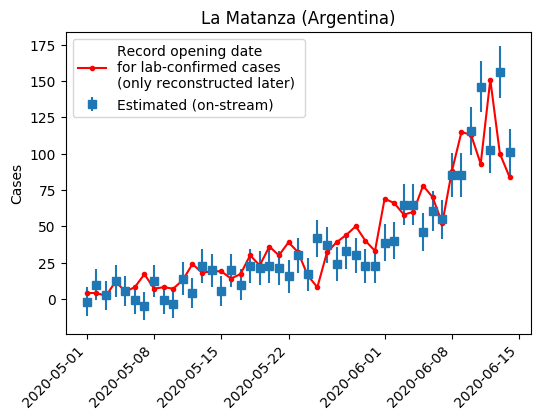

In [57]:
# Introduce district name from list
import datetime
testmuni = 'lamatanza'
today = datetime.date(2020,6,15)

key=districts.index[districts['Municipio'] == testmuni].tolist()
fromday = today - timedelta(days=45)
print('Plot will be from ',fromday,' to ',today)

real_cases = []
import datetime
delta = today - fromday
Ndays = int(delta.days)
data_individual=[]
for ndays in range(Ndays):    
    testday = fromday + timedelta(days=ndays)
    n_district = key[0]
    # Iterate on the district names
    tmp_district = districts['Municipio'][n_district]
    N_inhabitants = districts['Poblacion'][n_district]
    # Go through the whole calls df
    calls0 = 0
    Delta0 = 0
    calls0 = len(calls[(calls['Municipio'] == tmp_district) & (calls['Fecha y hora'] == testday)])
    real_cases.append([testday,len(cases[(cases['Municipio'] == tmp_district) & (cases['fecha_apertura'] == testday)])])
    expected_calls = B * N_inhabitants
    data_individual.append([tmp_district, N_inhabitants, expected_calls, calls0, testday])

alarm0=[]
for i in range(len(data_individual)):
    
    cases0 = (data_individual[i][3] - data_individual[i][2])/S95
    Dcases0 = sqrt( ( DB * data_individual[i][1])**2 + data_individual[i][2] + data_individual[i][3])/S95
    
    alarm0.append([districts0['Municipio'][key[0]],districts['Poblacion'][key[0]], cases0, Dcases0, data_individual[i][-1]])

# absolute = [Municipio, cases, 95%CL uncertainty, minimum cases @ 95%CL]
absolute0 = [[x[0],x[2],x[3],x[-1]] for x in alarm0]

testlist = absolute0
x = [x[-1] for x in testlist]
y = [x[1] for x in testlist]
e = [x[2]/1 for x in testlist]
plt.figure(dpi=100)
plt.errorbar(x, y, yerr=e, fmt='s',label='Estimated (on-stream)')
plt.plot([x[0] for x in real_cases],[x[1] for x in real_cases],'.r-',label='Record opening date\nfor lab-confirmed cases\n(only reconstructed later) ')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cases')
plt.title(str(testlist[0][0])+' (Argentina)')
plt.legend()
if not os.path.isdir('figs'): os.makedirs('figs')
plt.savefig('figs/lamatanza.png',bbox_inches='tight')
plt.show()


Plot will be from  2020-05-01  to  2020-06-15


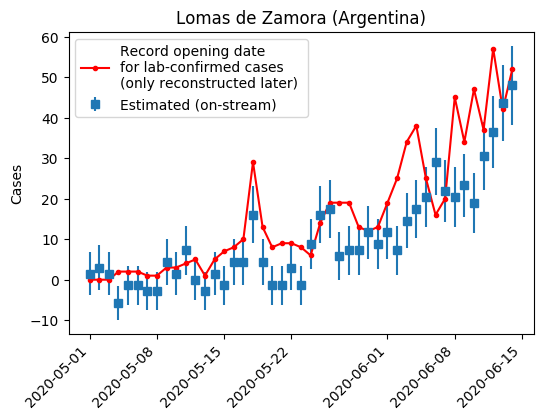

In [58]:
# Introduce district name from list
import datetime
testmuni = 'lomasdezamora'
today = datetime.date(2020,6,15)

key=districts.index[districts['Municipio'] == testmuni].tolist()
fromday = today - timedelta(days=45)
print('Plot will be from ',fromday,' to ',today)

real_cases = []
import datetime
delta = today - fromday
Ndays = int(delta.days)
data_individual=[]
for ndays in range(Ndays):    
    testday = fromday + timedelta(days=ndays)
    #print('Collecting calls from day '+str(testday)+' and district '+testmuni)
    n_district = key[0]
    # Iterate on the district names
    tmp_district = districts['Municipio'][n_district]
    N_inhabitants = districts['Poblacion'][n_district]
    # Go through the whole calls df
    calls0 = 0
    Delta0 = 0
    calls0 = len(calls[(calls['Municipio'] == tmp_district) & (calls['Fecha y hora'] == testday)])
    real_cases.append([testday,len(cases[(cases['Municipio'] == tmp_district) & (cases['fecha_apertura'] == testday)])])
    expected_calls = B * N_inhabitants
    data_individual.append([tmp_district, N_inhabitants, expected_calls, calls0, testday])

alarm0=[]
for i in range(len(data_individual)):
    
    cases0 = (data_individual[i][3] - data_individual[i][2])/S95
    Dcases0 = sqrt( ( DB * data_individual[i][1])**2 + data_individual[i][2] + data_individual[i][3])/S95
    
    alarm0.append([districts0['Municipio'][key[0]],districts['Poblacion'][key[0]], cases0, Dcases0, data_individual[i][-1]])

# absolute = [Municipio, cases, 95%CL uncertainty, minimum cases @ 95%CL]
absolute0 = [[x[0],x[2],x[3],x[-1]] for x in alarm0]

testlist = absolute0
#x = range(len(testlist))
x = [x[-1] for x in testlist]
y = [x[1] for x in testlist]
e = [x[2]/1 for x in testlist]
plt.figure(dpi=100)
plt.errorbar(x, y, yerr=e, fmt='s',label='Estimated (on-stream)')
plt.plot([x[0] for x in real_cases],[x[1] for x in real_cases],'.r-',label='Record opening date\nfor lab-confirmed cases\n(only reconstructed later) ')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cases')
#plt.axvline(x=datetime.date(2020,5,21), color='brown', linestyle=':',label='Comienzo de hisopados puerta-apuerta')
plt.title(str(testlist[0][0])+' (Argentina)')
plt.legend()
#plt.text(.05,.97,'ICAS.unsam.edu.ar\nMin.Salud PBA',ha='left',va='top', fontsize=12, color='gray',transform = plt.gca().transAxes)
if not os.path.isdir('figs'): os.makedirs('figs')
plt.savefig('figs/lomasdezamora.png',bbox_inches='tight')
plt.show()
